# Rule-based Models

## RuleFit

The following code fits a RuleFit model for spheres to the complete data and extracts the rules from the model. The model usually contains a mix of linear and rule terms (there is some randomisation). 

Note how the RuleFit package (here imported through the patch in realkd) requires that:

- the negative class is encoded with 0
- the covariates have to be given as a numpy array (i.e., pandas dataframe is not allowed)

These two aspects make the estimator tricky to handle with our standard experiment class (and potentially for the probabilistic chain wrapper). Moreover, the model does not provide the attribute `classes_` after fitting. This means that also the sklearn functions cannot evaluate the log loss for this model. This all can be fixed by further patching RuleFit are potentially adapting the `Experiment` class from `common`.

In [175]:
import data1 as data
from realkd.patch import RuleFit

x = data.x.filter(data.predictors, axis=1)
y = data.sphere

rf = RuleFit(rfmode='classify', model_type='rl', Cs=[1])
rf.fit(x.values, y.replace(-1, 0), feature_names=x.columns)
rules = rf.get_rules()
rules = rules[rules['coef'] > 0]
rules

,rule,type,coef,support,importance
9,mon_core_mw,linear,0.026805,1.000000,0.270298
10,mon_core_apol,linear,0.007982,1.000000,0.018844
11,mon_core_mv,linear,0.944255,1.000000,0.101864
127,core_mw_total <= 66026.0 & ratio_vol > 0.27323...,rule,0.170072,0.024490,0.026287
269,ratio_mass <= 0.26498904824256897 & core_mw_to...,rule,0.891693,0.028571,0.148555
383,core_mw_total <= 43223.25 & dp_core > 106.0 & ...,rule,0.887803,0.024490,0.137222
417,conc > 14.25 & core_mw_total <= 15828.89990234...,rule,0.589513,0.085714,0.165029
422,dp_corona <= 28.5 & core_mw_total <= 43151.960...,rule,0.410419,0.036735,0.077204
460,clogp_core <= 1.3700000047683716 & mon_core_mv...,rule,2.844037,0.118367,0.918745
504,dp_core <= 104.5 & core_mv_total > 93.61500167...,rule,0.247197,0.126531,0.082180


There are not too many rules and they can be ordered by importance, which is nice for interpretability. One thing that is confusing is that there are only positive coefficients.

Let us ignore this for now and investigate how well these models fit the data (as a function of the number of rules). Note that the parameter `Cs` can be used to give different options for regularisation. Generally, higher C-values lead to more rules. Presumably, when more than one C-value is provided, the best is determined via internal cross-validation.

First we produce a baseline accuracy with a random forest. Then we try out various C-values (not leaving the choice to RuleFit but providing one at a time to be able to see the effect of the different choices).

We use cross validation to get unbiased results of relatively low variance.

In [163]:
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier

K = 30
cv = KFold(K, shuffle=True, random_state=0)

forest = RandomForestClassifier()
forest_results = cross_validate(forest, x, y, cv=cv, scoring=['accuracy', 'neg_log_loss'], return_estimator=True, return_train_score=True)

forest_results['test_accuracy'].mean()

0.920175438596491

In [145]:
import numpy as np

Cs = [0.1, 0.5, 1, 2, 10]

rulefits = [RuleFit(rfmode='classify', model_type='rl', Cs=[C]) for C in Cs]
rulefit_results = []
for i in range(len(Cs)):
    rulefit_results.append(cross_validate(rulefits[i], x.values, y.replace(-1, 0), cv=cv, scoring=['accuracy'], return_estimator=True, return_train_score=True))
    rulefit_results[-1]['num_rules'] = np.array([(est.get_rules()['coef'] > 0).sum() for est in rulefit_results[-1]['estimator']])

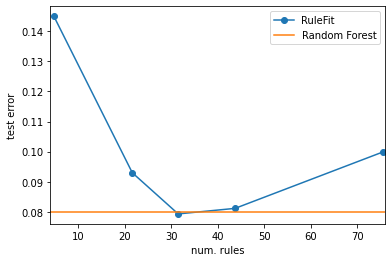

In [173]:
from matplotlib import pyplot as plt

k = [res['num_rules'].mean() for res in rulefit_results]
err = [1-res['test_accuracy'].mean() for res in rulefit_results]
plt.plot(k, err, marker='o', label='RuleFit')
k_min = min(k) // 1
k_max = round(max(k) + 0.5)
plt.plot([k_min, k_max], [1-forest_results['test_accuracy'].mean(), 1-forest_results['test_accuracy'].mean()], label='Random Forest')
# plt.plot([k_min, k_max], [1-forest_results['train_accuracy'].mean(), 1-forest_results['train_accuracy'].mean()])
plt.xlim(k_min, k_max)
plt.xlabel('num. rules')
plt.ylabel('test error')
plt.legend()
plt.show()

## Rule Boosting

An alternative approach to fitting a rule-based model is rule boosting.

In [176]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator

re = RuleBoostingEstimator(num_rules=5, base_learner=XGBRuleEstimator(loss='logistic', reg=1, search='greedy', search_params={'max_col_attributes': 20}), verbose=True)
re.fit(x, y)

   +1.4059 if conc<=20.0 & corona_mv_total>=82.15284000000001 & mon_core_psa<=46.53
   +1.6639 if mon_core_mw>=158.09 & mon_corona_apol>=23.529516
   -1.3778 if clogp_core<=1.12 & conc>=10.0 & corona_mv_total<=82.15284000000001 & dp_core>=104.2 & mon_core_psa<=46.53 & mon_corona_mw<=160.07
   +1.5082 if corona_mv_total>=46.200880000000005 & dp_corona<=78.0 & ratio_mass>=0.315052864 & ratio_vol>=0.300180918
   +2.8912 if core_mw_total>=16606.602 & corona_mv_total>=58.4539 & mon_corona_mw<=108.02 & mon_corona_psa<=26.3


RuleBoostingEstimator(max_rules=5, base_learner=XGBRuleEstimator(reg=1, loss=logistic))

In [179]:
re.num_rules += 10

In [177]:
from sklearn.metrics import accuracy_score

accuracy_score(y, re.predict(x))

0.7584459459459459

In [180]:
re.fit(x, y)

   +1.4288 if charged>=1 & mon_corona_psa<=26.3
   -1.1338 if conc>=13.0 & corona_mw_total>=7523.29 & dp_corona<=78.0 & mon_core_mw<=144.08 & mon_corona_psa>=66.76 & ratio_mass<=0.315052864
   +1.5289 if charged>=1 & clogp_core>=1.1 & conc<=20.0 & core_mw_total<=52805.856 & corona_mw_total<=9604.2 & ratio_vol<=0.300180918 & salt<=0.1 & temp>=70.0
   +1.7034 if core_mw_total<=26467.308 & dp_corona>=78.0
   +1.3769 if core_mv_total<=136.8531 & mon_core_mw>=158.09
   -0.8054 if conc<=20.0 & conc>=10.0 & corona_mw_total<=9604.2 & mon_core_mw<=144.08 & mon_corona_apol<=23.529516 & ph<=7.0
   +1.2593 if conc<=13.0 & conc>=10.0 & dp_corona>=78.0 & ratio_mass<=0.315052864 & ratio_mass>=0.1361396068
   +1.0785 if corona_mv_total>=46.200880000000005 & corona_mw_total<=10606.18 & dp_core<=104.2
   +0.7182 if core_mw_total>=52805.856 & dp_core>=353.6 & mon_core_mw>=144.08 & mon_corona_mw<=279.11
   -0.8743 if clogp_corona<=0.09 & conc>=20.0 & dp_core>=104.2 & dp_corona<=78.0 & mon_core_psa>=46.17 

RuleBoostingEstimator(max_rules=15, base_learner=XGBRuleEstimator(reg=1, loss=logistic))

In [181]:
accuracy_score(y, re.predict(x))

0.875